In [1]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.engine import  Model
from keras.layers import Flatten, Dense, Input
from keras_vggface.vggface import VGGFace

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from utils import load_data, load_test_data
from utils import num_classes, epochs, batch_size

#custom parameters
nb_class = 5

vgg_model = VGGFace(include_top=False, input_shape=(224, 224, 3), model='resnet50')
x = vgg_model.get_layer('avg_pool').output
x = Flatten(name='flatten')(x)
# x = Dropout(0.8)(x)
out = Dense(nb_class, activation='softmax', name='classifier')(x)
custom_vgg_model = Model(vgg_model.input, out)
custom_vgg_model.summary()

ModuleNotFoundError: No module named 'tensorflow.keras'

In [ ]:
data_dir_path = '.'
target_label_file_name = 'mapping.txt'

target_label_file_path = '/'.join((data_dir_path, target_label_file_name))

with open(target_label_file_path) as f:
    all_lines = [line.split(', ') for line in f.read().splitlines()]

target_labels = dict()
for line in all_lines:
    target_class, target_label = line
    target_labels[target_class] = target_label

In [ ]:
import os
import cv2
import pandas as pd
from glob import glob

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from time import time
# 指定存放 train 資料集的資料夾
train_dir = '/'.join((data_dir_path, 'training'))
img_path_list = []
img_class_list = []
for key in target_labels.keys():
    for file_path in glob('{}/{}/*.png'.format(train_dir, key)):
        img_class_list.append(target_labels[key])
        img_path_list.append(file_path)

data_list = pd.DataFrame({'class': img_class_list, 'path': img_path_list})

In [4]:
# 將資料清單隨機打亂
rand_seed = int(time())
data_list = shuffle(data_list, random_state=rand_seed)
data_list.head(10)

,class,path
119,1,./training/risa/071.png
516,4,./training/neru/009.png
340,3,./training/akane/092.png
182,1,./training/risa/057.png
451,4,./training/neru/092.png
230,2,./training/yui/061.png
487,4,./training/neru/088.png
429,4,./training/neru/047.png
273,2,./training/yui/081.png
414,3,./training/akane/097.png


In [5]:
X = pd.DataFrame(data_list['path'], columns=['path'])
y = pd.DataFrame(data_list['class'], columns=['class'])
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25)

In [6]:
y_one_hot=pd.get_dummies(y_train)
y_train=y_one_hot.values

In [7]:
y_one_hot1=pd.get_dummies(y_valid)
y_valid=y_one_hot1.values

In [8]:
import numpy as np
from keras.preprocessing import image
from keras_vggface.vggface import VGGFace
from keras_vggface import utils

imagearray = []
imagearray1 = []
# Change the image path with yours.
for path in np.array(X_train['path']):
    img = cv2.imread(path)
    img = cv2.resize(img, (224, 224))
    img = img.astype(np.float32)
    img=utils.preprocess_input(img, version=2)
    imagearray.append(img)
train_x=np.array(imagearray).astype(np.float32)
for path in np.array(X_valid['path']):
    img1 = cv2.imread(path)
    img1 = cv2.resize(img1, (224, 224))
    img1=img1.astype(np.float32)
    imagearray1.append(img1)
val_x=np.array(imagearray1).astype(np.float32)

In [9]:
val_x.shape

(136, 224, 224, 3)

In [10]:
from keras.optimizers import adam
model_name = 'VggFacev1'

datagen = ImageDataGenerator(
    rotation_range=10,
    fill_mode='nearest')

opt = adam(lr=1e-5, decay=1e-6)


model_path = './saved_models/{}.h5'.format(model_name)

checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

custom_vgg_model.compile(loss='categorical_crossentropy',
              optimizer=opt, metrics=['accuracy'])

batch_size = 10
model_history = custom_vgg_model.fit_generator(datagen.flow(train_x, y_train, batch_size = batch_size),
                                    steps_per_epoch=len(train_x)/batch_size,
                                    epochs = epochs,
                                    validation_data = (val_x, y_valid),
                                    callbacks = [checkpoint, earlystop])

Epoch 1/200
41/40 [==============================] - 13s 311ms/step - loss: 1.2790 - acc: 0.6024 - val_loss: 1.6497 - val_acc: 0.5882

Epoch 00001: val_loss improved from inf to 1.64967, saving model to ./saved_models/VggFacev1.h5
Epoch 2/200
41/40 [==============================] - 4s 109ms/step - loss: 0.1775 - acc: 0.9366 - val_loss: 1.2933 - val_acc: 0.6765

Epoch 00002: val_loss improved from 1.64967 to 1.29327, saving model to ./saved_models/VggFacev1.h5
Epoch 3/200
41/40 [==============================] - 4s 109ms/step - loss: 0.0573 - acc: 0.9854 - val_loss: 1.4046 - val_acc: 0.6544

Epoch 00003: val_loss did not improve from 1.29327
Epoch 4/200
41/40 [==============================] - 4s 109ms/step - loss: 0.0614 - acc: 0.9829 - val_loss: 1.1372 - val_acc: 0.6765

Epoch 00004: val_loss improved from 1.29327 to 1.13718, saving model to ./saved_models/VggFacev1.h5
Epoch 5/200
41/40 [==============================] - 4s 109ms/step - loss: 0.0271 - acc: 0.9951 - val_loss: 1.1636 -

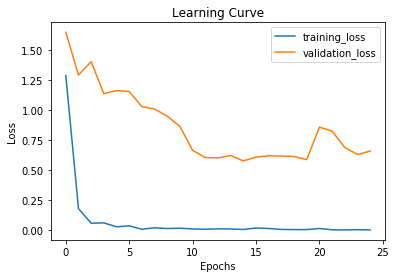

In [11]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

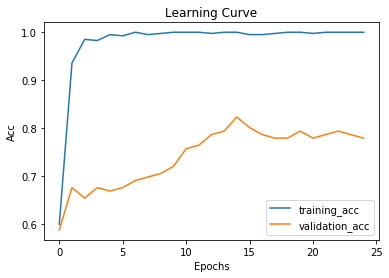

In [12]:
training_acc = model_history.history['acc']
val_acc = model_history.history['val_acc']

plt.plot(training_acc, label="training_acc")
plt.plot(val_acc, label="validation_acc")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

In [13]:
import os
import cv2
import pandas as pd
from glob import glob
data_dir_path = './'
testset_dir = '/'.join((data_dir_path, 'testing'))
img_path_list = []
for img_path in glob('{}/*.png'.format(testset_dir)):
    img_path_list.append(img_path)


In [14]:
import numpy as np
from keras.preprocessing import image
from keras_vggface.vggface import VGGFace
from keras_vggface import utils
X_test = []
X_id = []
for path in img_path_list:
    img = cv2.imread(path)
    img = cv2.resize(img, (224, 224))
    img = img.astype(np.float32)
    img=utils.preprocess_input(img, version=2)
    X_test.append(img)
    img_id = path.split('/')[-1].split('.')[0]
    X_id.append(img_id)
test_data=np.array(X_test).astype(np.float32)

In [15]:
from tensorflow.keras.models import Sequential, load_model, Model
model_name = 'VggFacev1'
model_path = './saved_models/{}.h5'.format(model_name)
model = load_model(model_path)

y_test_pred_prob = model.predict(test_data)
y_test_pred = y_test_pred_prob.argmax(axis=-1)
y_test_pred_df = pd.DataFrame({'id': np.array(X_id), 'class':y_test_pred}).sort_values(by='id')
y_test_pred_df.to_csv('./submissions/{}.csv'.format(model_name), index=False)